In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [3]:
batch_size=32
image_size=256
channels=3

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage',
    seed=123,
    shuffle=True,
    image_size=(image_size,image_size),
    batch_size=batch_size
)

Found 2152 files belonging to 3 classes.


In [9]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [11]:
for image_batch,labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


In [21]:
for image_batch,labels_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


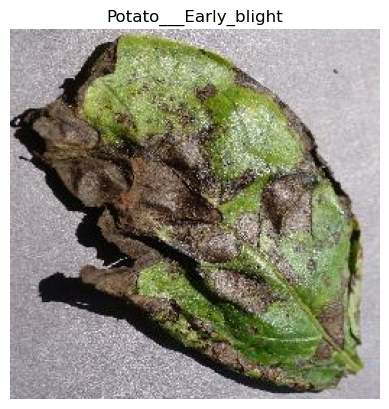

In [49]:
for image_batch,labels_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    plt.title(class_names[labels_batch[0]])
    plt.axis('off')

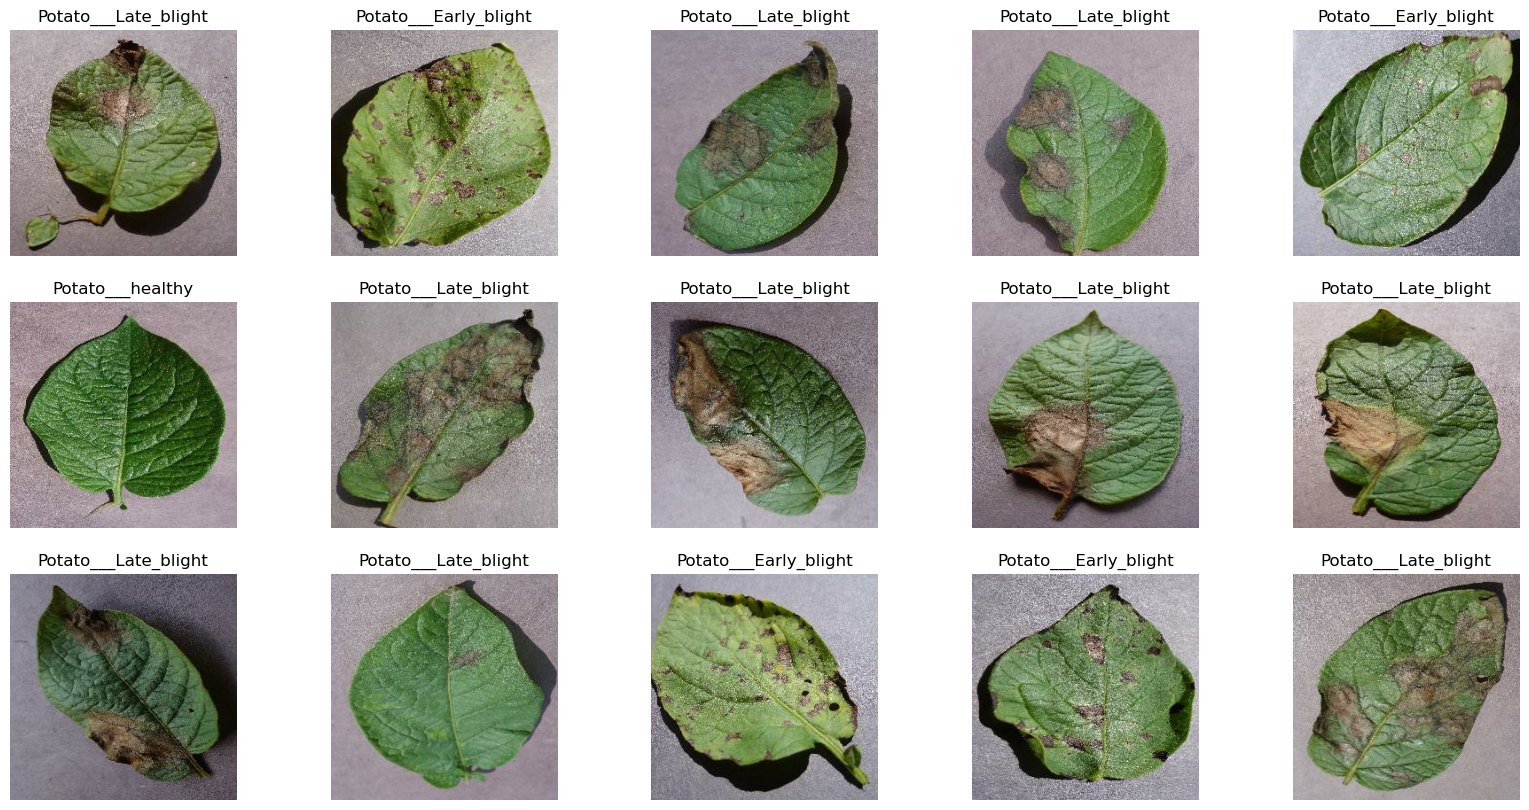

In [85]:
plt.figure(figsize=(20,10))
for image_batch,labels_batch in dataset.take(1):
    for i in range(15):
        ax = plt.subplot(3,5,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[labels_batch[i]])
        plt.axis('off')

In [87]:
len(dataset)

68

In [89]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [91]:
54*32

1728

In [93]:
train_ds = dataset.take(54)
len(train_ds)

54

In [95]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [97]:
val_size = 0.1
len(dataset)*0.1

6.800000000000001

In [99]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [101]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [105]:
def dataset_partitions(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=1000):
    ds_size = len(ds)
    train_size = int(train_split*ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [107]:
train_ds,val_ds,test_ds = dataset_partitions(dataset)

In [111]:
len(train_ds)

54

In [113]:
len(test_ds)

8

In [117]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [131]:
resize_rescale = tf.keras.Sequential([
    layers.Resizing(image_size,image_size),
    layers.RandomRotation(0.2),
])

In [133]:
data_aug = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)
])

In [139]:
train_ds = train_ds.map(lambda x,y:(data_aug(x,training = True),y)
                       ).prefetch(buffer_size=tf.data.AUTOTUNE)

In [143]:
input_shape = (batch_size,image_size,image_size,channels)
n_classes = 3
model = models.Sequential([
    resize_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax'),
])
model.build(input_shape=input_shape)

C:\Users\karth\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [145]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [147]:
model.compile(optimizer = 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [149]:
history = model.fit(train_ds,batch_size=batch_size,
                    validation_data=val_ds,
                    verbose=1,
                    epochs=10)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.5266 - loss: 2.0846 - val_accuracy: 0.6927 - val_loss: 0.7517
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.6727 - loss: 0.7092 - val_accuracy: 0.7292 - val_loss: 0.6791
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.7958 - loss: 0.4742 - val_accuracy: 0.7344 - val_loss: 0.7283
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.8476 - loss: 0.3614 - val_accuracy: 0.7396 - val_loss: 0.9002
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.8653 - loss: 0.3262 - val_accuracy: 0.8229 - val_loss: 0.5199
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.9182 - loss: 0.2217 - val_accuracy: 0.8385 - val_loss: 0.5384
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.8514 - loss: 0.3686 - val_accuracy: 0.8021 - val_loss: 1.0901
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.8954 - loss: 0.2555 - val_accuracy: 0.7344 - v

In [156]:
score = model.evaluate(test_ds)
score

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.8631 - loss: 0.3948


[0.38145163655281067, 0.857758641242981]

In [158]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

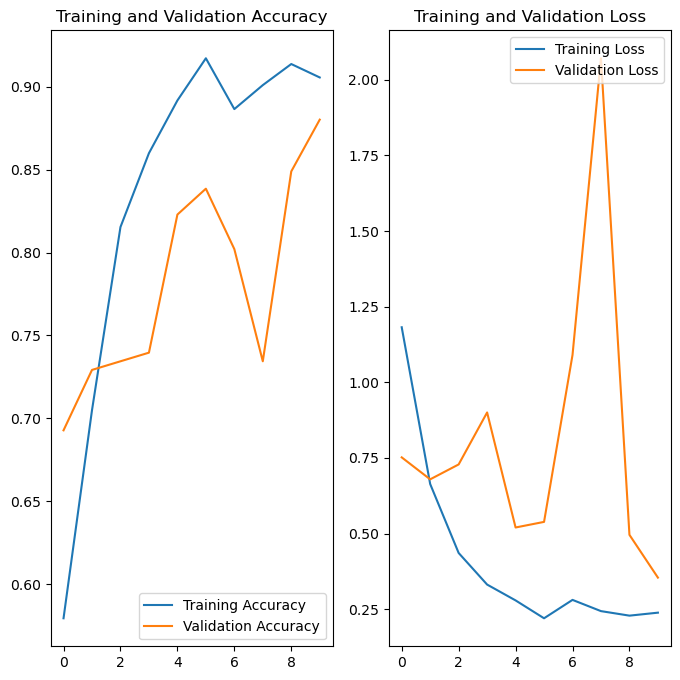

In [162]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(10), acc, label='Training Accuracy')
plt.plot(range(10), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(10), loss, label='Training Loss')
plt.plot(range(10), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [172]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


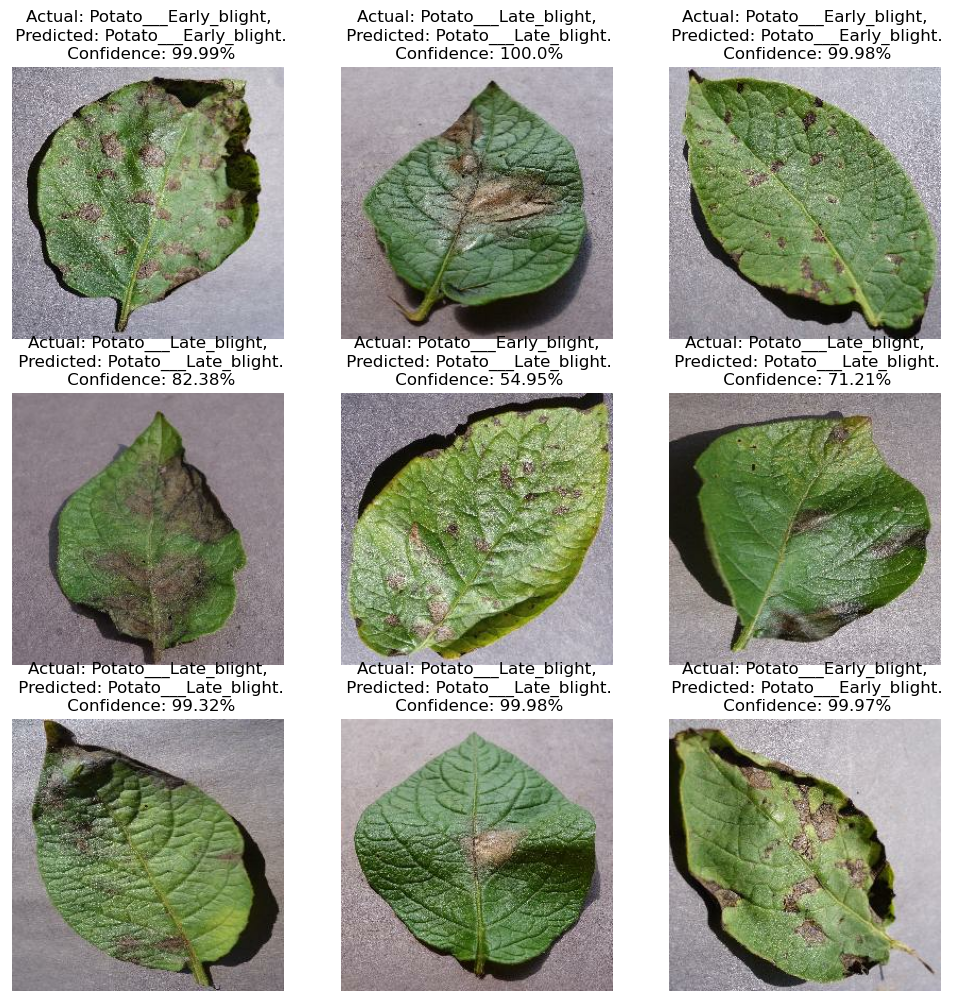

In [184]:
import numpy as np
plt.figure(figsize=(12, 12))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [191]:
import pickle
name = 'potato_model'

pickle.dump(model,open(name,'wb'))